# Conditional Monte Carlo

Let $X$ and $Z$ be random vectors, and let $Y=\psi(X)$ be another random vector. Also, suppose that we set:


$$V=\mathbb{E}\left[Y|Z\right]$$

Then, $V$ is a random variable itself that depends on $Z$, so we can write $V=g(Z)$ for some function $g(\cdot)$.

From the **Law of Total Expectation**, we also have that $\mathbb{E}V=\mathbb{E}\left[\mathbb{E}\left[Y|Z\right]\right]=\mathbb{E}Y$.

Then, if we are trying to estimate $\theta=\mathbb{E}Y=\mathbb{E}V,\;\text{we can simulate }V=\mathbb{E}\left[Y|Z\right]\;\text{instead of }Y$, and approximate $\theta=\mathbb{E}Y$ by the Monte Carlo estimation of  $\mathbb{E}V$.

To determine whether $\hat{\theta_1}=\frac{1}{N}\sum_{i=1}^{N}Y_i\;\text{or }\hat{\theta_2}=\frac{1}{N}\sum_{i=1}^{N}\mathbb{E}(Y_i|Z_i)$ is the most efficient estimator (since both of them are unbiased), we compare their variances:

From the **Law of Total Variation** we have that: $Var(Y) = Var\left[\mathbb{E}(Y|Z)\right] + \mathbb{E}\left[Var(Y|Z)\right]=Var(V) + \mathbb{E}\left[Var(Y|Z)\right]$ and so, $Var(Y)\geq Var(V)$.

Therefore, simulating the conditional expectation $V=\mathbb{E}\left[Y|Z\right]$ is better for the estimation of $\theta=\mathbb{E}Y=\mathbb{E}V$ than estimating explicitly $Y$.

The difficulty lies in that if we want to estimate $\theta=\mathbb{E}\left[\mathbb{E}\left[Y|Z\right]\right]$ using $\hat{\theta_2}=\frac{1}{N}\sum_{i=1}^{N}\mathbb{E}(Y|Z_i)$, where $\mathbb{E}\hat{\theta_2}=\theta$, we first need to simulate $Z$, and then simulate $Y|Z$ to estimate $\mathbb{E}(Y|Z_i)\;\text{as } \frac{1}{M}\sum_{j=1}^{M}Y_j|Z_i$ which introduces additional variation, since essentially we would be simulating: 


$$\theta=\mathbb{E}\left[\mathbb{E}\left[Y|Z\right]\right]\approx \frac{1}{N}\sum_{i=1}^{N}\left[\frac{1}{M}\sum_{j=1}^{M}Y_j|Z_i\right]$$.

But, if we can compute $\mathbb{E}(Y|Z_i)$ explicitly with a closed-form solution, we can accomplish variance reduction by avoiding noise from simulating $Y|Z$, since we only need to simulate $Z$ one time, and then compute $\theta=\mathbb{E}\left[\mathbb{E}\left[Y|Z\right]\right]\approx \frac{1}{N}\sum_{i=1}^{N}\mathbb{E}(Y|Z_i)$.

# Options Pricing with Conditional Monte Carlo-Romano and Touzi

Assume that the underlying asset price follows the Heston Stochastic Volatility model under a risk-neutral probability measure $\mathbb{Q}$,

$$\frac{dS_t}{S_t}=rdt+\sqrt{X_t}\underbrace{\left(\rho dB_t+\sqrt{1-\rho^2}dW_t\right)}_{Z_t}
\\
dX_t=\kappa(\theta-X_t)dt+ \sigma\sqrt{X_t}dB_t$$,

where $B_t,\;W_t\overset{iid} \sim N(0, t)$ are two independent Standard $\mathbb{Q}$-Brownian Motions, and $B_t, Z_t$ are two correlated Standard $\mathbb{Q}$-Brownian Motions.

The stochastic volatility term $X_t$ follows a CIR process.

Using Conditional Monte Carlo and the formula of Romano and Touzi, the SV model's call price is given by:

$$C^{SV}(s, x, T)=\mathbb{E}\left[\left(C^{bs}\left(se^{Z}, \sigma(X), T\right)|Z, \sigma^2(X)\right)\right]$$,

where $C^{bs}(s, \sigma, T)$ denotes the Black-Scholes call price and 

$$Z=\rho \int_{0}^{T}\sqrt{X_t}dB_t  - \frac{\rho^2}{2}\int_{0}^{T}X_tdt
\\
\sigma^2(X)=\frac{1-\rho^2}{T}\int_{0}^{T} X_tdt
$$

where 
$Z\;\text{and }\sigma^2(X)$ are the conditional variables used to estimate the Conditional Expectation $C^{SV}=V=\mathbb{E}\left[\mathbb{E}\left[Y|Z\right]\right]=\mathbb{E}\left[\left(C^{bs}|Z, \sigma^2(X)\right)\right]$.

We compare the Standard Monte Carlo method with the Conditional Monte Carlo method in estimating the European call price using 20,000 Monte Carlo sample paths. We let $S_0=100,\;r=0.05,\;T=3/12,\;q=0.$ 

We take the CIR parameters to be $X_0=0.2,\;\kappa=3,\;\theta=0.2,\;\sigma=\sqrt{2\theta\kappa}$ and adjust $\rho$ to be $\rho \in\{-0.7, -0.3, 0\}$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import *

### Initial Parameters

In [2]:
S0 = 100
r = 0.05
T = 3 / 12
M = 20000 # Number of Monte Carlo sample paths
dt = 1 / 365 # Step size to simulate the SDEs
n = int(T / dt) # Number of discretization steps
K = np.arange(90, 121, 5)
disc = exp(-r * T)

# CIR Initial Parameters
X0 = 0.2
k = 3
theta = 0.2
sigma  = sqrt(2 * theta * k) # Vol-of-vol parameter
rho = -0.7

# 1. Standard Monte Carlo

### Simulate the SDEs

In [3]:
# Empty array to store the stochastic-volatility paths
X = np.ones((M, n)) * X0

# Empty array to store the log-price of the underlying asset paths
Y = np.ones((M, n)) * log(S0)

# Sample two independent (M, n) Standard Brownian Motions
dB = np.random.normal(0, 1, (M, n)) * sqrt(dt)
dW = np.random.normal(0, 1, (M, n)) * sqrt(dt)

# Given the two independent Brownian Motions, compute the correlated Brownian Motion  Z used in the Heston SV model
dZ = (rho * dB) + sqrt(1 - (rho ** 2)) * dW

# Euler-Maruyama to simulate the SDEs
for j in range(1, n):
    
    # Simulate the CIR process of the Stochastic-Volatility with the forward Euler - Maruyama method
    # modified to enforce a real  value
    X[:, j] = (1 - k * dt) * X[:, j - 1]  + (k * theta * dt) + sigma * np.sqrt(np.maximum(X[:, j-1], 0)) * dB[:, j-1]
    
    # Given the stochastic volatility value at time node (j - 1), simulate the log-price of the underlying asset at time node j
    # We use np.sqrt(max(Xj, 0)) because the CIR process can hit negative values
    Y[:, j] = Y[:, j - 1] + (r - 0.5 * X[:, j - 1]) * dt + np.sqrt(np.maximum(X[:, j - 1], 0)) * dZ[:, j - 1]
    
# Exponentiate to obtain the underlying asset paths
S = np.exp(Y)

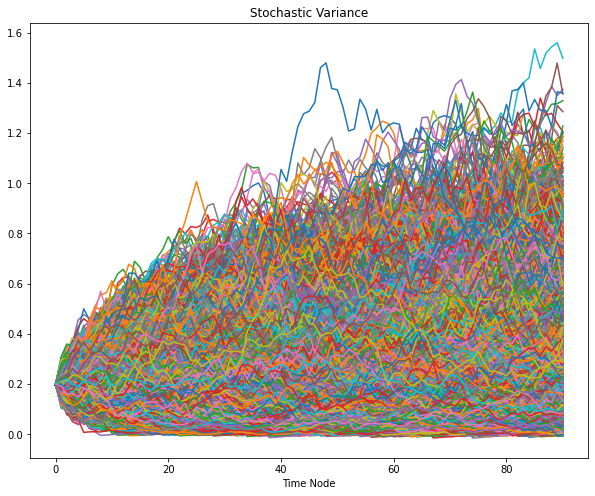

In [4]:
plt.figure(figsize=(10, 8))
plt.plot(X.T)
plt.xlabel("Time Node")
plt.title("Stochastic Variance")
plt.show()

In [5]:
# Average number of times per path that the stochastic variance hits negative values
av_negative = (X < 0).sum(axis = 1).mean()
print(f"The Stochastic Variance hits negative values an average of {av_negative} times per sample path.")

The Stochastic Variance hits negative values an average of 0.1648 times per sample path.


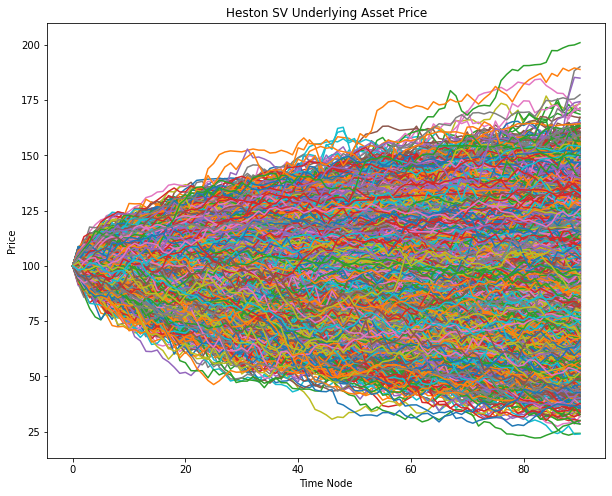

In [6]:
plt.figure(figsize=(10, 8))
plt.plot(S.T)
plt.xlabel("Time Node")
plt.ylabel("Price")
plt.title("Heston SV Underlying Asset Price")
plt.show()

### Price the European call options

In [7]:
# Extract the terminal asset values
S_terminal = S[:, -1]

# Create the Strike x Terminal Price space
[S_last, K_grid] = np.meshgrid(S_terminal, K)

# Compute the final payoffs
final_payoffs = np.maximum(S_last - K_grid, 0)

# Compute the European call price as the discounted expectation of the final payoff
call_prices_standard_mc = disc * final_payoffs.mean(axis = 1)

# 2. Conditional Monte Carlo 

Recall that the Stochastic Volatility model's European call price given by Romano and Touzi is:

$$C^{SV}(s, x, T)=\mathbb{E}\left[\left(C^{bs}\left(se^{Z}, \sigma(X), T\right)|Z(X), \sigma^2(X)\right)\right],$$

where $C^{bs}(s, \sigma, T)$ denotes the Black-Scholes call price and 

$$Z(X)=\rho \int_{0}^{T}\sqrt{X_t}dB_t  - \frac{\rho^2}{2}\int_{0}^{T}X_tdt
\\
\sigma^2(X)=\frac{1-\rho^2}{T}\int_{0}^{T} X_tdt
$$

are the conditional variables used to estimate the Conditional Expectation.

Because the stochastic integrals $\int_{0}^{T}\sqrt{X_t}dB_t,\;\text{and } \int_{0}^{T}X_tdt$, where $X_t$ follows a CIR process, cannot be computed explicitly, we approximate them using Monte Carlo integration. Let:

$$I_1=\int_{0}^{T}\sqrt{X_t}dB_t\approx\sum_{i=1}^{n}\sqrt{X_i^+}\Delta B_i
\\
I_2=\int_{0}^{T}X_tdt\approx\Delta t\sum_{i=1}^{n}X_i$$

where $n$ denotes the number of discretization nodes (time steps).

For each Monte Carlo sample path of $X_t$, we obtain 1 approximate value for the integrals $I_1,\;I_2$ for a total of $M$ approximate integral values. These values in turn produce $M$ Monte Carlo samples for the Conditional Variables $Z,\;\sigma^2$, which are the inputs to the BS formula.<br>
Using the $M$ Monte Carlo samples of the Conditional Variables: $Z_i,\;\sigma(X)_i$, we compute $M$ BS values of the European call, and then approximate the SV model's call price as: 

$$C^{SV}=\mathbb{E}\left[\mathbb{E}(Y|Z)\right]\approx\frac{1}{M}\sum_{i=1}^{M}\mathbb{E}\left(Y|Z_i\right)=\frac{1}{M}\sum_{i=1}^{M}\left[C^{bs}|Z_i, \sigma^2(X)_i\right]$$


In [8]:
from py_vollib_vectorized.models import vectorized_black_scholes_merton as bs
from py_vollib_vectorized.implied_volatility import vectorized_implied_volatility as imp_vol_bs
import time

### Approximate the Integrals and compute the value of the Conditional Variates

We use the Stochastic Volatility $X_t$ paths simulated before in step 1.

In [9]:
# Compute the Integrals
I1 = (np.sqrt(np.maximum(X, 0)) * dB).sum(axis = 1)
I2 = X.sum(axis = 1) * dt

# Use the Integral approximations to compute the values of the Conditional Variates
Z = (rho * I1) - (0.5 * (rho ** 2)) * I2
sigma_squared = ((1 - (rho ** 2)) / T) * I2

# Compute the inputs of the BS formula
s = S0 * np.exp(Z)
stochastic_sigma = np.sqrt(sigma_squared)

### Compute the Conditional Monte Carlo call price using the mean of the (M) BS prices

To price all the calls simultaneously in the strike space we have to obtain as output of the BS formula an array of shape $ (Strike \text{ x } M) $. Thus, we create the $(Strike\text{ x } M)$ space for both Conditional Variates that are inputs to the vectorized BS function using np.meshgrid().

In [10]:
[s_grid, _] = np.meshgrid(s, K)
[stochastic_sigma_grid, _] =np.meshgrid(stochastic_sigma, K)

In [11]:
s_grid.shape

(7, 20000)

In [12]:
stochastic_sigma_grid.shape

(7, 20000)

In [13]:
K_grid.shape

(7, 20000)

In [14]:
# Obtain the BS values (Strike x M) shape-M BS call values for each strike
bs_values = bs("c", s_grid, K_grid, T, r, stochastic_sigma_grid, 0, return_as="np").reshape(7, -1)

# Approximate the Call prices using Conditional Monte Carlo estimation
call_prices_conditional_mc = bs_values.mean(axis = 1)

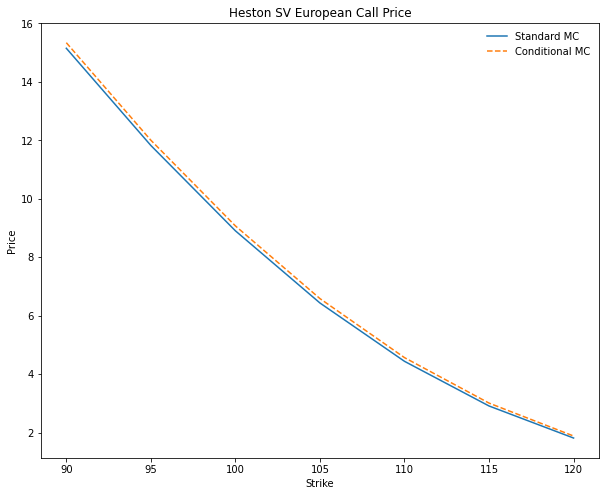

In [15]:
plt.figure(figsize=(10, 8))
plt.plot(K, call_prices_standard_mc, label="Standard MC")
plt.plot(K, call_prices_conditional_mc, label="Conditional MC", linestyle="--")
plt.title("Heston SV European Call Price")
plt.ylabel("Price")
plt.xlabel("Strike")
plt.legend(frameon=False)
plt.show()

# Compute 100 Standard and Conditional MC Estimators and test their Efficiency

Both the Standard and the Conditional Monte Carlo estimators of the Heston SV model's European call price are *Unbiased*. However, as we established in the theoretical result in the introduction, the variance of the Conditional MC estimator is always less than or equal to the variance of the Standard MC estimator. Below we test this result empirically by constructing 100 MC estimators using both methods and compare their variance. We perform the analysis iteratively for $\rho \in \{0, -0.3, -0.7 \}$.

In [16]:
rho_list = [0, -0.3, -0.7]

# Empty list to store the Average call prices of the MC & CMC estimators for different rho values
average_call_prices = []

# Empty list to store the Standard Errors of the MC & CMC estimators for different rho prices
standard_errors = []

# Empty list to store the Implied Volatilites of the call prices of the MC & CMC estimators for different rho values
average_imp_vols = []

# Empty list to store the Standard Errors of the MC & CMC implied volatilities for different rho values
standard_errors_imp_vol = []

# Start countings
tick = time.time()

for rho in rho_list:
    
    # Empty lists to store the MC estimators
    call_standard_mc = []
    call_conditional_mc = []
    imp_vol_standard_mc = []
    imp_vol_conditional_mc = []

    for i in range(100):

        """ A.) Standard MC estimator of the Call price in the Strike space"""


        # Empty array to store the stochastic-volatility paths
        X = np.ones((M, n)) * X0

        # Empty array to store the log-price of the underlying asset paths
        Y = np.ones((M, n)) * log(S0)

        # Sample two independent (M, n) Standard Brownian Motions
        dB = np.random.normal(0, 1, (M, n)) * sqrt(dt)
        dW = np.random.normal(0, 1, (M, n)) * sqrt(dt)

        # Given the two independent Brownian Motions, compute the correlated Brownian Motion  Z used in the Heston SV model
        dZ = (rho * dB) + sqrt(1 - (rho ** 2)) * dW

        """Euler-Maruyama to simulate the SDEs"""

        for j in range(1, n):

            # Simulate the CIR process of the Stochastic-Volatility with the forward Euler - Maruyama method
            # modified to enforce a real  value
            X[:, j] = (1 - k * dt) * X[:, j - 1]  + (k * theta * dt) + sigma * np.sqrt(np.maximum(X[:, j-1], 0)) * dB[:, j-1]

            # Given the stochastic volatility value at time node (j - 1), simulate the log-price of the underlying asset at time node j
            # We use np.sqrt(max(Xj, 0)) because the CIR process can hit negative values
            Y[:, j] = Y[:, j - 1] + (r - 0.5 * X[:, j - 1]) * dt + np.sqrt(np.maximum(X[:, j - 1], 0)) * dZ[:, j - 1]

        # Exponentiate to obtain the underlying asset paths
        S = np.exp(Y)

        """Price the European call"""

        # Extract the terminal asset values
        S_terminal = S[:, -1]

        # Create the Strike x Terminal Price space
        [S_last, K_grid] = np.meshgrid(S_terminal, K)

        # Compute the final payoffs
        final_payoffs = np.maximum(S_last - K_grid, 0)

        # Compute the European call price as the discounted expectation of the final payoff
        call_prices_standard_mc = disc * final_payoffs.mean(axis = 1)

        # Collect the Standard MC estimators to the list
        call_standard_mc.append(call_prices_standard_mc)
        
        # Extract the Implied Volatilities
        implied_vol_standard_mc = imp_vol_bs(call_prices_standard_mc, S0, K, T, r, "c", q=0)
        
        # Collect the Implied Volatilites to the list
        imp_vol_standard_mc.append(implied_vol_standard_mc)

        """ B.) Conditional MC estimator of the Call price in the Strike space"""

        """Approximate the Integrals and compute the value of the Conditional Variates"""

        # Compute the Integrals
        I1 = (np.sqrt(np.maximum(X, 0)) * dB).sum(axis = 1)
        I2 = X.sum(axis = 1) * dt

        # Use the Integral approximations to compute the values of the Conditional Variates
        Z = (rho * I1) - (0.5 * (rho ** 2)) * I2
        sigma_squared = ((1 - (rho ** 2)) / T) * I2

        # Compute the inputs of the BS formula
        s = S0 * np.exp(Z)
        stochastic_sigma = np.sqrt(sigma_squared)

        """Compute the Conditional Monte Carlo call price using the mean of the (M) BS prices"""

        [s_grid, _] = np.meshgrid(s, K)
        [stochastic_sigma_grid, _] =np.meshgrid(stochastic_sigma, K)

        # Obtain the BS values (Strike x M) shape-M BS call values for each strike
        bs_values = bs("c", s_grid, K_grid, T, r, stochastic_sigma_grid, 0, return_as="np").reshape(7, -1)

        # Approximate the Call prices using Conditional Monte Carlo estimation
        call_prices_conditional_mc = bs_values.mean(axis = 1)

        # Collect the Conditional MC estimators to the list
        call_conditional_mc.append(call_prices_conditional_mc)
        
        # Extract the Implied Volatilities
        implied_vol_conditional_mc = imp_vol_bs(call_prices_conditional_mc, S0, K, T, r, "c", q=0)
        
        # Collect the Implied Volatilites to the list
        imp_vol_conditional_mc.append(implied_vol_conditional_mc)


    """Extract the Average MC Call prices and the Standard Errors"""   
    # Extract the MC estimators and transform them to dataframes
    standard_mc_est = pd.DataFrame(np.array(call_standard_mc).T, index=K)
    standard_mc_est.index.rename("Strike", inplace=True)

    conditional_mc_est = pd.DataFrame(np.array(call_conditional_mc).T, index=K)
    conditional_mc_est.index.rename("Strike", inplace=True) 

    # Compute and collect the Average call prices across the 100 MC estimators
    average_call_price = pd.concat([standard_mc_est.mean(axis = 1).rename("Standard MC"), conditional_mc_est.mean(axis = 1).rename("Conditional MC")], axis=1)
    average_call_prices.append(average_call_price)
    
    # Compute and collect the Standard Errors of the MC estiamtors
    standard_error = pd.concat([standard_mc_est.std(axis = 1).rename("Standard MC"), conditional_mc_est.std(axis = 1).rename("Conditional MC")], axis=1)
    standard_errors.append(standard_error)
    
    """Extract the Average Implied Volatilities and the Standard Errors"""
    
    # Extract the Implied Volatilites and transform the to dataframes
    standard_mc_imp_vol = pd.DataFrame(np.array(imp_vol_standard_mc).reshape(-1, 7).T, index=K)
    standard_mc_imp_vol.index.rename("Strike", inplace=True)
    
    conditional_mc_imp_vol = pd.DataFrame(np.array(imp_vol_conditional_mc).reshape(-1, 7).T, index=K)
    conditional_mc_imp_vol.index.rename("Strike", inplace=True)
    
    # Compute and collect the Average call prices across the 100 MC estimators
    average_imp_vol = pd.concat([standard_mc_imp_vol.mean(axis = 1).rename("Imp Vol Standard MC"), conditional_mc_imp_vol.mean(axis = 1).rename("Imp Vol Conditional MC")], axis=1)
    average_imp_vols.append(average_imp_vol.round(4))
    
    # Compute and collect the Standard Errors of the Implied Volatility estimators
    standard_error_imp_vol = pd.concat([standard_mc_imp_vol.std(axis = 1).rename("Standard MC"), conditional_mc_imp_vol.std(axis = 1).rename("Conditional MC")], axis=1)
    standard_errors_imp_vol.append(standard_error_imp_vol.round(4))
       
    
tock = time.time()

moneyness = (S0 - K) / K
print(f"Execution time: {round((tock - tick) / 60, 2)} minutes")


Execution time: 1.75 minutes


### MC Estimators

In [17]:
print("The Average of the 100 MC Estimators for rho values of 0, -0.3 and -0.7 respectively are:\n ")

for i, df in enumerate(average_call_prices):
    print("Rho value: " + str(rho_list[i]) +"\n", df)

The Average of the 100 MC Estimators for rho values of 0, -0.3 and -0.7 respectively are:
 
Rho value: 0
         Standard MC  Conditional MC
Strike                             
90        14.869096       14.919908
95        11.740205       11.793799
100        9.110091        9.164321
105        6.971745        7.024710
110        5.282704        5.332892
115        3.979413        4.024775
120        2.990000        3.029267
Rho value: -0.3
         Standard MC  Conditional MC
Strike                             
90        15.076054       15.115939
95        11.845356       11.891494
100        9.076873        9.127269
105        6.790767        6.842322
110        4.973529        5.023004
115        3.580793        3.624987
120        2.545699        2.583307
Rho value: -0.7
         Standard MC  Conditional MC
Strike                             
90        15.291190       15.340110
95        11.952163       12.002597
100        9.019596        9.070616
105        6.533464        6.583

In [18]:
print("The Standard Deviation of the 100 MC Estimators for rho values of 0, -0.3 and -0.7 respectively are:\n")
 
for i, df in enumerate(standard_errors):
    print("Rho value: " + str(rho_list[i]) +"\n", df)

The Standard Deviation of the 100 MC Estimators for rho values of 0, -0.3 and -0.7 respectively are:

Rho value: 0
         Standard MC  Conditional MC
Strike                             
90         0.131128        0.014357
95         0.122988        0.016468
100        0.114305        0.017680
105        0.104471        0.017873
110        0.093245        0.017166
115        0.081751        0.015827
120        0.072062        0.014147
Rho value: -0.3
         Standard MC  Conditional MC
Strike                             
90         0.121083        0.021143
95         0.111641        0.016205
100        0.102468        0.011962
105        0.092985        0.008872
110        0.083876        0.007039
115        0.074120        0.006056
120        0.065030        0.005378
Rho value: -0.7
         Standard MC  Conditional MC
Strike                             
90         0.110553        0.066942
95         0.100562        0.056881
100        0.089568        0.046380
105        0.077082   

### Plot the MC Estimators of the call price and their Standard Errors

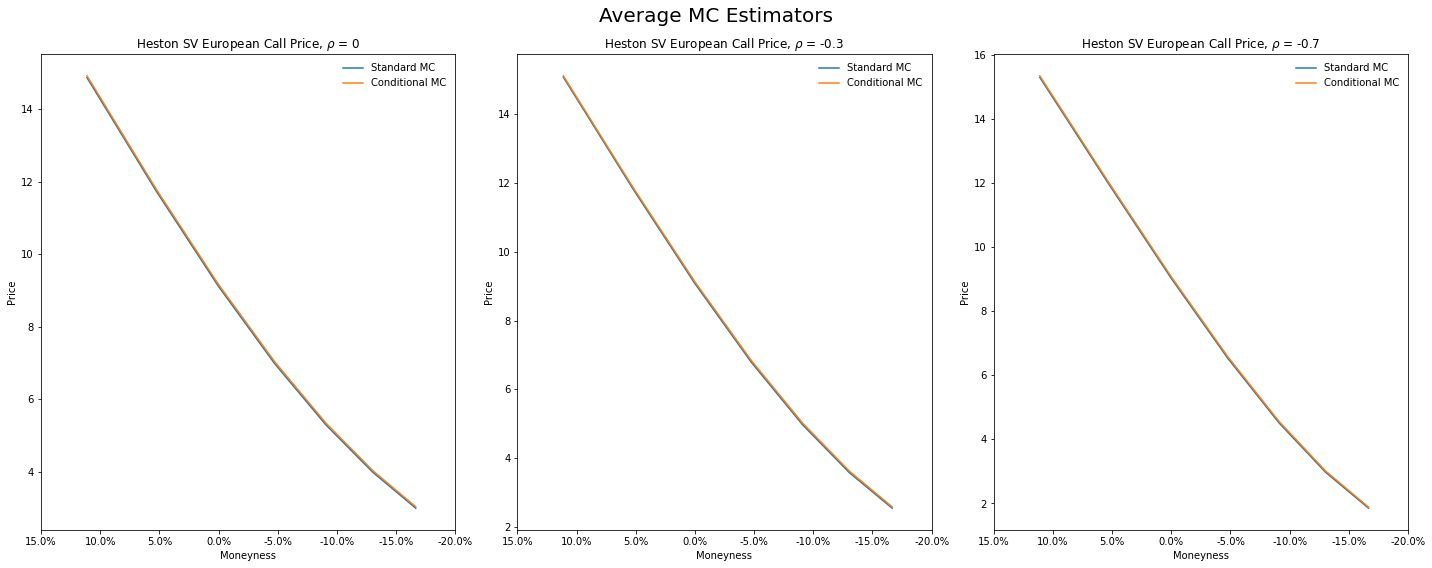

In [19]:
# Plot the Average of the 100 MC Estimators of the two methods
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

# Flatten the axes to iterate over
axs = axs.flatten()

for i, df in enumerate(average_call_prices):
    
    df.set_axis(moneyness).plot(ax = axs[i])
    axs[i].invert_xaxis()
    axs[i].set_title("Heston SV European Call Price," + r" $\rho$ = " + str(rho_list[i]))
    axs[i].legend(frameon=False)
    axs[i].set_ylabel("Price")
    axs[i].set_xlabel("Moneyness")
    xticks = axs[i].get_xticks()
    xlabs = [str(round(100 * tick, 2)) +"%" for tick in xticks]
    axs[i].set_xticks(ticks = xticks, labels = xlabs)

plt.suptitle("Average MC Estimators", fontsize=20)
plt.tight_layout()
plt.show()

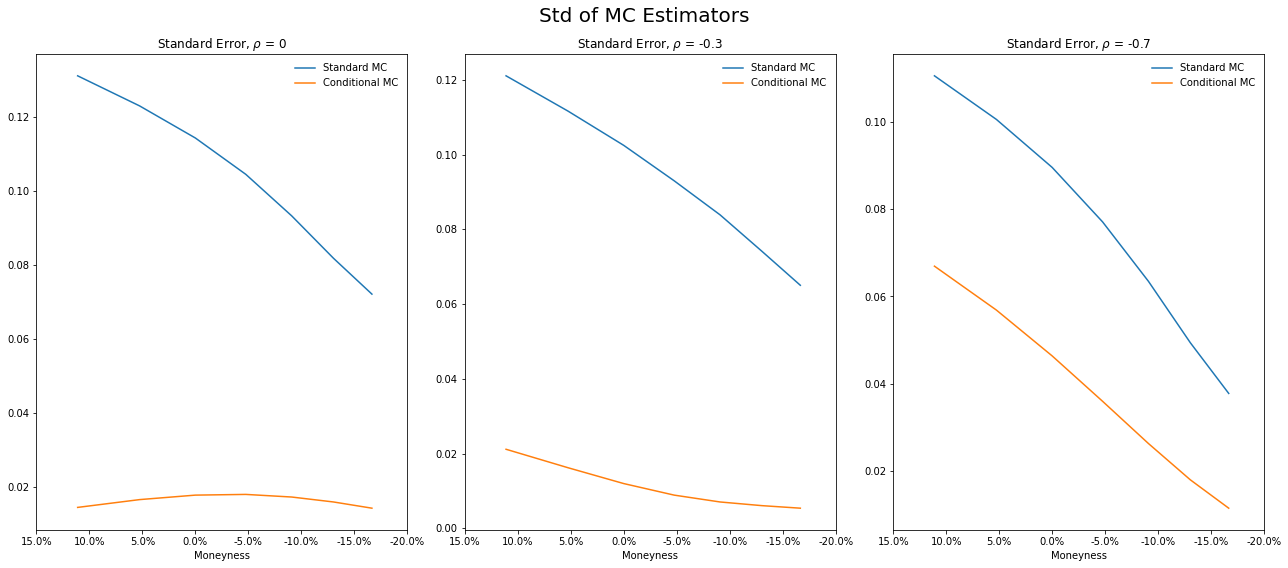

In [20]:
# Plot the Standard Errors
fig, axs = plt.subplots(1, 3, figsize=(18, 8))
# Flatten the axis to iterate over
axs=axs.flatten()

for i, df in enumerate(standard_errors):
    
    df.set_index(moneyness).plot(ax= axs[i])
    axs[i].invert_xaxis()
    axs[i].legend(frameon=False)
    axs[i].set_title("Standard Error, " + r"$\rho$ = " + str(rho_list[i]))
    axs[i].set_xlabel("Moneyness")
    xticks = axs[i].get_xticks()
    xlabs = [str(round(100 * tick, 2)) + "%" for tick in xticks]
    axs[i].set_xticks(ticks = xticks, labels=xlabs)
    
plt.suptitle("Std of MC Estimators", fontsize=20)    
plt.tight_layout()
plt.show()

### Implied Volatilities

In [21]:
print("The Average Implied Volatilites for rho values of 0, -0.3 and -0.7 respectively are:\n ")

for i, df in enumerate(average_imp_vols):
    print("Rho value: " + str(rho_list[i]) +"\n", df)

The Average Implied Volatilites for rho values of 0, -0.3 and -0.7 respectively are:
 
Rho value: 0
         Imp Vol Standard MC  Imp Vol Conditional MC
Strike                                             
90                   0.4328                  0.4360
95                   0.4296                  0.4325
100                  0.4283                  0.4311
105                  0.4289                  0.4315
110                  0.4309                  0.4335
115                  0.4343                  0.4368
120                  0.4385                  0.4410
Rho value: -0.3
         Imp Vol Standard MC  Imp Vol Conditional MC
Strike                                             
90                   0.4456                  0.4481
95                   0.4353                  0.4378
100                  0.4266                  0.4292
105                  0.4198                  0.4224
110                  0.4148                  0.4174
115                  0.4117                  0.414

In [22]:
print("The Standard Deviation of the Implied Volatilities for rho values of 0, -0.3 and -0.7 respectively are:\n")

for i, df in enumerate(standard_errors_imp_vol):
    print("Rho value: " + str(rho_list[i]) +"\n", df)

The Standard Deviation of the Implied Volatilities for rho values of 0, -0.3 and -0.7 respectively are:

Rho value: 0
         Standard MC  Conditional MC
Strike                             
90           0.0081          0.0009
95           0.0067          0.0009
100          0.0058          0.0009
105          0.0052          0.0009
110          0.0049          0.0009
115          0.0046          0.0009
120          0.0045          0.0009
Rho value: -0.3
         Standard MC  Conditional MC
Strike                             
90           0.0075          0.0013
95           0.0061          0.0009
100          0.0052          0.0006
105          0.0047          0.0004
110          0.0044          0.0004
115          0.0042          0.0003
120          0.0042          0.0003
Rho value: -0.7
         Standard MC  Conditional MC
Strike                             
90           0.0068          0.0041
95           0.0055          0.0031
100          0.0046          0.0024
105          0.0039

### Plot the errors of the Implied Volatilities

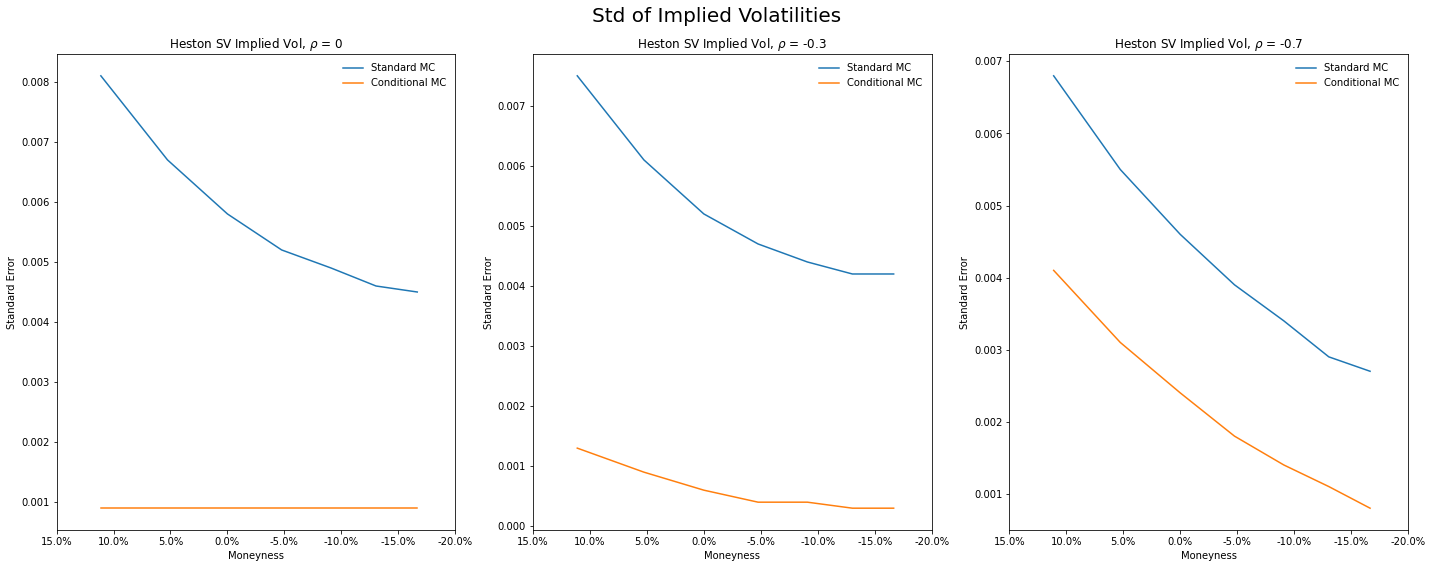

In [23]:
# Plot the Average of the 100 MC Estimators of the two methods
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

# Flatten the axes to iterate over
axs = axs.flatten()

for i, df in enumerate(standard_errors_imp_vol):
    
    df.set_axis(moneyness).plot(ax = axs[i])
    axs[i].invert_xaxis()
    axs[i].set_title("Heston SV Implied Vol," + r" $\rho$ = " + str(rho_list[i]))
    axs[i].legend(frameon=False)
    axs[i].set_ylabel("Standard Error")
    axs[i].set_xlabel("Moneyness")
    xticks = axs[i].get_xticks()
    xlabs = [str(round(100 * tick, 2)) +"%" for tick in xticks]
    axs[i].set_xticks(ticks = xticks, labels = xlabs)

plt.suptitle("Std of Implied Volatilities", fontsize=20)
plt.tight_layout()
plt.show()

# Conclusions

It is evident that the Conditional Monte Carlo method reduces significantly the variance of the MC estimators of the call price, and is the most efficient method. The same fact holds also true for the computation of the implied volatilities. The greatest variance reduction is accomplished when $\rho=0$, and as $|\rho|\;\uparrow$, the effectiveness of the method attenuates.

Also, the amount of variance reduction depends on the moneyness of the options. First, for ITM options the standard error of both the MC and the CMC estimators is higher. Also, for all possible values of $\rho$, the variance reduction is higher for ITM options and as we move to OTM the magnitude of the variance reduction becomes smaller.
